Front Matter

In [ ]:
import numpy as np
import pylab as plt
import seaborn as sns
import time
from collections import Counter
from tqdm import tqdm
from numba import njit, prange

In [ ]:
import random
random.seed(321)

Basic Method for L = 1 to 15

In [ ]:
moves = [(0,1), (0,-1), (1,0), (-1,0)]

def count_saws(L):
    stack = [(0, 0, 0, set([(0, 0)]))]  # (x, y, Steps, Visited_set)
    saw_count = 0

    while stack:
        x, y, steps, visited = stack.pop()

        if steps == L:
            saw_count += 1
            continue

        for dx, dy in moves:
            new_x, new_y = x + dx, y + dy

            if (new_x, new_y) not in visited:
                new_visited = visited.copy()
                new_visited.add((new_x, new_y))
                stack.append((new_x, new_y, steps + 1, new_visited))

    return saw_count

saw_counts = []

for L in range(1, 21):
    count = count_saws(L)
    saw_counts.append(count)
    print(f"c{L} = {count}")

print("Saw counts for comparison:", saw_counts)

#35mins to run until L=20

c1 = 4
c2 = 12
c3 = 36
c4 = 100
c5 = 284
c6 = 780
c7 = 2172
c8 = 5916
c9 = 16268
c10 = 44100
c11 = 120292
c12 = 324932
c13 = 881500
c14 = 2374444
c15 = 6416596
c16 = 17245332
c17 = 46466676
c18 = 124658732
c19 = 335116620
c20 = 897697164
Saw counts for comparison: [4, 12, 36, 100, 284, 780, 2172, 5916, 16268, 44100, 120292, 324932, 881500, 2374444, 6416596, 17245332, 46466676, 124658732, 335116620, 897697164]


Basic Monte Carlo I:

In [ ]:
def generate_random_walk(L):
    """Generate a random walk of length L starting from the origin (0, 0)."""
    walk = [(0, 0)]  # Start at the origin
    for _ in range(L):
        # Choose a random direction: up, down, left, or right
        x, y = walk[-1]
        direction = random.choice([(0, 1), (0, -1), (1, 0), (-1, 0)])
        new_position = (x + direction[0], y + direction[1])
        walk.append(new_position)
    return walk

def is_self_avoiding(walk):
    """Check if a walk is self-avoiding (no revisits)."""
    return len(walk) == len(set(walk))  # No revisits if walk length matches the number of unique positions

def monte_carlo_simulation(L, num_walks=10000):
    """Estimate the fraction of self-avoiding walks using Monte Carlo method."""
    count_self_avoiding = 0

    for _ in range(num_walks):
        walk = generate_random_walk(L)
        if is_self_avoiding(walk):
            count_self_avoiding += 1

    fraction = count_self_avoiding / num_walks
    return fraction

# Estimate the fraction of self-avoiding walks for L = 10 to 20
num_walks = 10000

for L in range(10, 21):
    fraction = monte_carlo_simulation(L, num_walks)
    print(f"Fraction of self-avoiding walks for L={L}: {fraction:.4f}")

Fraction of self-avoiding walks for L=10: 0.0432
Fraction of self-avoiding walks for L=11: 0.0284
Fraction of self-avoiding walks for L=12: 0.0205
Fraction of self-avoiding walks for L=13: 0.0138
Fraction of self-avoiding walks for L=14: 0.0086
Fraction of self-avoiding walks for L=15: 0.0049
Fraction of self-avoiding walks for L=16: 0.0040
Fraction of self-avoiding walks for L=17: 0.0031
Fraction of self-avoiding walks for L=18: 0.0018
Fraction of self-avoiding walks for L=19: 0.0014
Fraction of self-avoiding walks for L=20: 0.0003


In [ ]:
import time
start_time = time.time()

# Predefined direction vectors (right, left, up, down)
DIRS = np.array([[1, 0], [-1, 0], [0, 1], [0, -1]])

def generate_walks_batch(L, batch_size):
    """Generate a batch of random walks of length L."""
    # Random directions for all walks (shape: batch_size x L)
    choices = np.random.randint(0, 4, size=(batch_size, L))
    steps = DIRS[choices]  # Map to step vectors

    # Cumulative sum to get positions (add origin (0,0) in front)
    origin = np.zeros((batch_size, 1, 2), dtype=int)
    walks = np.concatenate([origin, np.cumsum(steps, axis=1)], axis=1)
    return walks

def is_self_avoiding_batch(walks):
    """Check which walks in the batch are self-avoiding."""
    batch_size, L_plus_1, _ = walks.shape
    # Convert positions to a hashable type (e.g., view as structured array)
    flat_walks = walks.view([('', walks.dtype)] * 2).reshape(batch_size, L_plus_1)

    # Count number of unique steps in each walk
    unique_counts = np.array([len(np.unique(flat_walks[i])) for i in range(batch_size)])
    return unique_counts == L_plus_1  # True if all positions are unique

def monte_carlo_simulation_fast(L, num_walks=1000000, batch_size=1000):
    """Fast estimation using batched vectorized Monte Carlo."""
    count_self_avoiding = 0
    remaining = num_walks

    while remaining > 0:
        current_batch = min(batch_size, remaining)
        walks = generate_walks_batch(L, current_batch)
        is_saw = is_self_avoiding_batch(walks)
        count_self_avoiding += np.sum(is_saw)
        remaining -= current_batch

    return count_self_avoiding / num_walks

# Estimate fractions from L = 10 to 20
num_walks = 1000000

for L in range(10, 21):
    fraction = monte_carlo_simulation_fast(L, num_walks)
    print(f"Fraction of self-avoiding walks for L={L}: {fraction:.4f}")

print("--- %s seconds ---" % (time.time() - start_time))

Fraction of self-avoiding walks for L=10: 0.0423
Fraction of self-avoiding walks for L=11: 0.0289
Fraction of self-avoiding walks for L=12: 0.0192
Fraction of self-avoiding walks for L=13: 0.0132
Fraction of self-avoiding walks for L=14: 0.0089
Fraction of self-avoiding walks for L=15: 0.0058
Fraction of self-avoiding walks for L=16: 0.0040
Fraction of self-avoiding walks for L=17: 0.0027
Fraction of self-avoiding walks for L=18: 0.0019
Fraction of self-avoiding walks for L=19: 0.0012
Fraction of self-avoiding walks for L=20: 0.0008
--- 234.33008337020874 seconds ---


In [ ]:
moves=[(0,1), (0,-1), (1,0), (-1,0)]

def estimate_saw_fraction(L, N):
    saw_count = 0
    for _ in range(N):
        x, y = 0, 0
        path = [(x, y)]

        for _ in range(L):
            dx, dy = moves[np.random.randint(0, 4)]  # Pick direction
            x, y = x + dx, y + dy

            if (x, y) in path:  # Check for overlap
                break
            path.append((x, y))
        else:
            saw_count += 1
    return saw_count / N

N=100_000
for L in range(1, 21):
    fraction = estimate_saw_fraction(L, N)
    print(f"L = {L}, Estimated SAW fraction: {fraction:.6f}")

L = 1, Estimated SAW fraction: 1.000000
L = 2, Estimated SAW fraction: 0.749410
L = 3, Estimated SAW fraction: 0.560560
L = 4, Estimated SAW fraction: 0.389820
L = 5, Estimated SAW fraction: 0.276850
L = 6, Estimated SAW fraction: 0.189980
L = 7, Estimated SAW fraction: 0.130760
L = 8, Estimated SAW fraction: 0.089820
L = 9, Estimated SAW fraction: 0.062600
L = 10, Estimated SAW fraction: 0.042190
L = 11, Estimated SAW fraction: 0.027800
L = 12, Estimated SAW fraction: 0.019470
L = 13, Estimated SAW fraction: 0.013260
L = 14, Estimated SAW fraction: 0.008710
L = 15, Estimated SAW fraction: 0.006080
L = 16, Estimated SAW fraction: 0.003970
L = 17, Estimated SAW fraction: 0.002800
L = 18, Estimated SAW fraction: 0.001700
L = 19, Estimated SAW fraction: 0.001070
L = 20, Estimated SAW fraction: 0.000800


Basic Monte Carlo II:

In [ ]:
DIRS = [(1, 0), (-1, 0), (0, 1), (0, -1)]

def add(pos, direction):
    return (pos[0] + direction[0], pos[1] + direction[1])

def importance_sampling_walk_with_trapped(L):
    walk = [(0, 0)]
    visited = set(walk)
    weights = []

    for _ in range(L):
        current = walk[-1]
        neighbors = [add(current, d) for d in DIRS]
        valid_moves = [n for n in neighbors if n not in visited]
        m = len(valid_moves)

        if m == 0:
            return walk, 0  # trapped walk, zero weight

        weights.append(m)
        next_step = random.choice(valid_moves)
        walk.append(next_step)
        visited.add(next_step)

    walk_weight = np.prod(weights)
    return walk, walk_weight

def estimate_cL_importance_sampling_with_stuck(L, num_samples=100000):
    weights = []
    stuck_count = 0

    for _ in range(num_samples):
        _, w = importance_sampling_walk_with_trapped(L)
        weights.append(w)
        if w == 0:
            stuck_count += 1

    estimated_cL = np.mean(weights)
    stuck_ratio = stuck_count / num_samples
    return estimated_cL, stuck_ratio

# Run for L = 10 to 20
for L in range(10, 21):
    cL, stuck = estimate_cL_importance_sampling_with_stuck(L, num_samples=100000)
    print(f"L = {L}: Estimated c_L ≈ {cL:.2f}, Stuck Walks: {stuck:.2%}")


L = 10: Estimated c_L ≈ 44130.28, Stuck Walks: 0.96%
L = 11: Estimated c_L ≈ 120174.84, Stuck Walks: 1.47%
L = 12: Estimated c_L ≈ 324793.54, Stuck Walks: 2.01%
L = 13: Estimated c_L ≈ 879317.93, Stuck Walks: 2.63%
L = 14: Estimated c_L ≈ 2381758.21, Stuck Walks: 3.40%
L = 15: Estimated c_L ≈ 6409095.70, Stuck Walks: 4.19%
L = 16: Estimated c_L ≈ 17233915.64, Stuck Walks: 5.02%
L = 17: Estimated c_L ≈ 46469264.90, Stuck Walks: 5.84%
L = 18: Estimated c_L ≈ 124566229.03, Stuck Walks: 6.76%
L = 19: Estimated c_L ≈ 334113378.24, Stuck Walks: 7.74%
L = 20: Estimated c_L ≈ 898033489.35, Stuck Walks: 8.77%


This method finds the probability of SAW by finding the number of successful SAW and dividing it by the total number of trails.

Since the probability of a success SAW is approx (mu^L)/4^L, and mu^L is approx equal to Cn, rearranging the formula we can get Cn is approx 4^L * prob.

In [ ]:
moves = [(0, 1), (1, 0), (0, -1), (-1, 0)]

def generate_walk_with_q(L):
    x, y = 0, 0
    path = [(x, y)]
    visited = set(path)
    q_prob = 1.0

    for _ in range(L):
        valid_moves = [(x + dx, y + dy) for dx, dy in moves if (x + dx, y + dy) not in visited]
        num_valid = len(valid_moves)

        if num_valid == 0:
            return path, q_prob, False  # got stuck early

        next_step = random.choice(valid_moves)
        q_prob *= 1 / num_valid  # update q(x)
        x, y = next_step
        path.append((x, y))
        visited.add((x, y))

    return path, q_prob, True  # walk of full length L

def estimate_cL_importance(L, N):
    ratios = []  # stores p(x_i)/q(x_i)
    for _ in range(N):
        path, q_prob, complete = generate_walk_with_q(L)
        if complete:
            k = len(path) - 1
            p_prob = (1 / 4) ** k
            r = p_prob / q_prob
            ratios.append(r)

    if not ratios:
        return 0, 0.0

    total_weight = sum(ratios)
    normalized_weights = [r / total_weight for r in ratios]
    cL_est = (4 ** L) * sum(normalized_weights)  # sum of w_i is 1

    return len(ratios), cL_est




**Advanced MC methods**

Rosenbluth

In [ ]:
DIRS = np.array([[1, 0], [-1, 0], [0, 1], [0, -1]])

def rosenbluth_walk(L):
    walk = [(0, 0)]
    visited = set(walk)
    weight = 1.0

    for _ in range(L):
        x, y = walk[-1]
        neighbors = [(x + dx, y + dy) for dx, dy in DIRS]
        valid_moves = [pos for pos in neighbors if pos not in visited]

        if not valid_moves:
            return None, 0.0  # Walk is trapped

        next_pos = valid_moves[np.random.randint(len(valid_moves))]
        walk.append(next_pos)
        visited.add(next_pos)
        weight *= len(valid_moves)

    return walk, weight

def estimate_cL(L, num_samples=10000):
    total_weight = 0
    valid_walks = 0
    for _ in range(num_samples):
        _, weight = rosenbluth_walk(L)
        if weight > 0:
            total_weight += weight
            valid_walks += 1
    return total_weight / valid_walks if valid_walks > 0 else 0

def get_successful_weights(L, num_samples=10000):
    weights = []
    for _ in range(num_samples):
        _, weight = rosenbluth_walk(L)
        if weight > 0:
            weights.append(weight)
    return np.array(weights)


In [ ]:
L_values = np.arange(10,460)
mu_estimates = []

for L in L_values:
    cL = estimate_cL(L, num_samples=10000)
    mu_L = cL ** (1 / L) if cL > 0 else np.nan
    mu_estimates.append(mu_L)

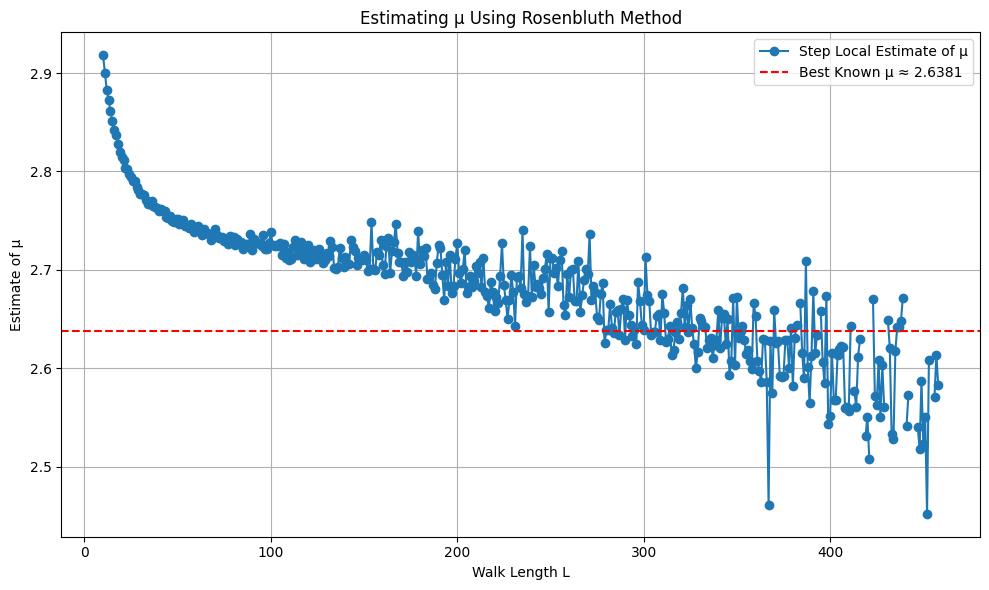

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(L_values, mu_estimates, marker='o', linestyle='-', label=r'Step Local Estimate of μ')
plt.axhline(2.6381, linestyle='--', color='red', label="Best Known μ ≈ 2.6381")
plt.xlabel('Walk Length L')
plt.ylabel(r'Estimate of μ')
plt.title(r'Estimating μ Using Rosenbluth Method')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Generating weights for L = 10...
Generating weights for L = 60...
Generating weights for L = 110...
Generating weights for L = 160...
Generating weights for L = 210...
Generating weights for L = 260...
Generating weights for L = 310...
Generating weights for L = 360...
Generating weights for L = 410...
Generating weights for L = 460...


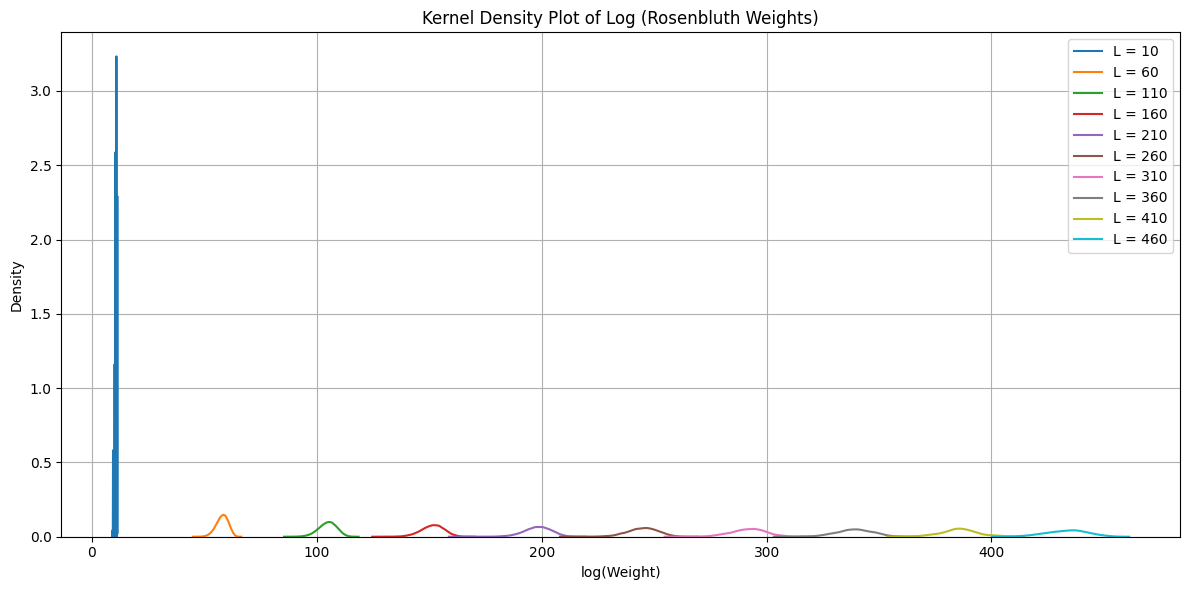

In [ ]:
L_values = [10, 60, 110, 160, 210, 260, 310, 360, 410, 460]
all_weights = {}

for L in L_values:
    print(f"Generating weights for L = {L}...")
    weights = get_successful_weights(L, num_samples=1000000)
    all_weights[L] = np.log(weights)  # log scale to manage skew

# Plot kernel density of log(weights)
plt.figure(figsize=(12, 6))

for L in L_values:
    if len(all_weights[L]) > 0:
        sns.kdeplot(all_weights[L], label=f'L = {L}')

plt.title('Kernel Density Plot of Log (Rosenbluth Weights)')
plt.xlabel('log(Weight)')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Generating weights for L = 60...
486277
Generating weights for L = 110...
181473
Generating weights for L = 160...
62445
Generating weights for L = 210...
20723
Generating weights for L = 260...
6826
Generating weights for L = 310...
2172
Generating weights for L = 360...
719
Generating weights for L = 410...
225
Generating weights for L = 460...
74


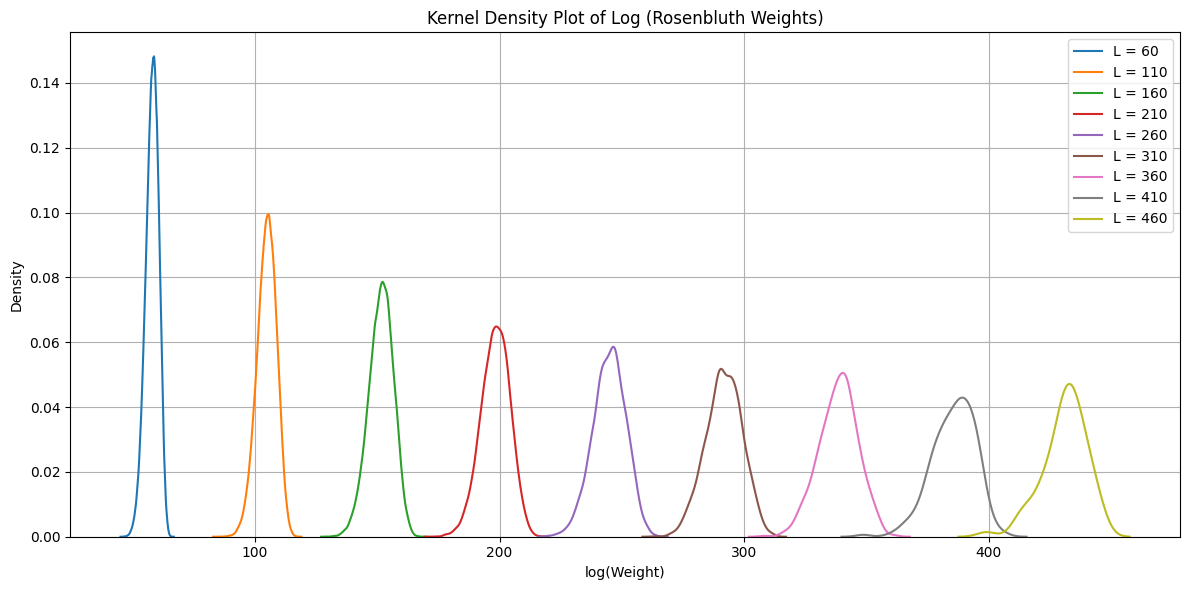

In [ ]:
L_values = [60, 110, 160, 210, 260, 310, 360, 410, 460]
all_weights = {}

for L in L_values:
    print(f"Generating weights for L = {L}...")
    weights = get_successful_weights(L, num_samples=1000000)
    print(len(weights))
    all_weights[L] = np.log(weights)  # log scale to manage skew


plt.figure(figsize=(12, 6))

for L in L_values:
    if len(all_weights[L]) > 0:
        sns.kdeplot(all_weights[L], label=f'L = {L}')

plt.title('Kernel Density Plot of Log (Rosenbluth Weights)')
plt.xlabel('log(Weight)')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

SMC

Averaged SMC

In [ ]:
dirs = [(0,1), (0,-1), (1,0), (-1,0)]

def add(p, d):
    return (p[0] + d[0], p[1] + d[1])

def get_unvisited_neighbors(walk):
    visited = set(walk)
    head = walk[-1]
    return [add(head, d) for d in dirs if add(head, d) not in visited]

def resample(walks, weights, N):
    weights = np.array(weights)
    if weights.sum() == 0:
        return walks  # avoid division by zero
    weights = weights / weights.sum()
    indices = np.random.choice(len(walks), size=N, p=weights)
    return [walks[i][:] for i in indices]

def count_duplicates(walks):
    walk_tuples = [tuple(walk) for walk in walks]
    counter = Counter(walk_tuples)
    duplicates = {walk: count for walk, count in counter.items() if count > 1}
    return len(duplicates)

def pivot_move(walk):
    if len(walk) <= 2:
        return walk
    pivot_index = random.randint(1, len(walk) - 2)
    pivot_point = walk[pivot_index]
    direction = random.choice(["rotate90", "rotate270", "reflect_x", "reflect_y"])
    transformed = []

    for i in range(pivot_index + 1, len(walk)):
        dx = walk[i][0] - pivot_point[0]
        dy = walk[i][1] - pivot_point[1]
        if direction == "rotate90":
            new_dx, new_dy = -dy, dx
        elif direction == "rotate270":
            new_dx, new_dy = dy, -dx
        elif direction == "reflect_x":
            new_dx, new_dy = dx, -dy
        elif direction == "reflect_y":
            new_dx, new_dy = -dx, dy
        new_pos = (pivot_point[0] + new_dx, pivot_point[1] + new_dy)
        transformed.append(new_pos)

    new_walk = walk[:pivot_index + 1] + transformed
    if len(set(new_walk)) == len(new_walk):
        return new_walk
    return walk


def smc(N=10000, max_L=1000):
    walks = [[(0, 0)] for _ in range(N)]
    extension_ratios = []

    for L in tqdm(range(1, max_L+1), desc="Running SMC"):
        new_walks = []
        weights = []

        for walk in walks:
            candidates = get_unvisited_neighbors(walk)
            w = len(candidates)
            weights.append(w)

            if w > 0:
                step = random.choice(candidates)
                walk.append(step)
                new_walks.append(walk)
            else:
                new_walks.append(walk)

        walks = resample(new_walks, weights, N)

        # Apply pivoting to introduce diversity
        walks = [pivot_move(walk) for walk in walks]

        extension_ratios.append(np.mean(weights))

        if L % 200 == 0:
            num_duplicates = count_duplicates(walks)
            if num_duplicates > 0:
                print(f"[L={L}] Duplicate walks: {num_duplicates}")

    c_ratios = np.array(extension_ratios)
    mu_estimate = np.prod(c_ratios)**(1 / len(c_ratios))
    return mu_estimate, extension_ratios

mu, ratios = smc(N=10000, max_L=3400)

Running SMC:   6%|▌         | 200/3400 [01:40<52:14,  1.02it/s]

[L=200] Duplicate walks: 1363


Running SMC:  12%|█▏        | 400/3400 [06:23<1:37:40,  1.95s/it]

[L=400] Duplicate walks: 1543


Running SMC:  18%|█▊        | 600/3400 [13:56<2:08:05,  2.74s/it]

[L=600] Duplicate walks: 1613


Running SMC:  24%|██▎       | 800/3400 [23:51<2:27:55,  3.41s/it]

[L=800] Duplicate walks: 1659


Running SMC:  29%|██▉       | 1000/3400 [35:45<2:54:21,  4.36s/it]

[L=1000] Duplicate walks: 1677


Running SMC:  35%|███▌      | 1200/3400 [49:24<2:54:03,  4.75s/it]

[L=1200] Duplicate walks: 1768


Running SMC:  41%|████      | 1400/3400 [1:05:49<3:13:08,  5.79s/it]

[L=1400] Duplicate walks: 1812


Running SMC:  47%|████▋     | 1600/3400 [1:24:12<3:10:50,  6.36s/it]

[L=1600] Duplicate walks: 1800


Running SMC:  53%|█████▎    | 1800/3400 [1:43:51<2:59:47,  6.74s/it]

[L=1800] Duplicate walks: 1813


Running SMC:  59%|█████▉    | 2000/3400 [2:05:14<2:52:50,  7.41s/it]

[L=2000] Duplicate walks: 1894


Running SMC:  65%|██████▍   | 2200/3400 [2:28:23<2:33:17,  7.66s/it]

[L=2200] Duplicate walks: 1867


Running SMC:  71%|███████   | 2400/3400 [2:53:18<2:19:38,  8.38s/it]

[L=2400] Duplicate walks: 1830


Running SMC:  76%|███████▋  | 2600/3400 [3:19:59<1:59:06,  8.93s/it]

[L=2600] Duplicate walks: 1858


Running SMC:  82%|████████▏ | 2800/3400 [3:48:24<1:37:54,  9.79s/it]

[L=2800] Duplicate walks: 1887


Running SMC:  88%|████████▊ | 3000/3400 [4:18:20<1:06:42, 10.01s/it]

[L=3000] Duplicate walks: 1961


Running SMC:  94%|█████████▍| 3200/3400 [4:50:55<35:40, 10.70s/it]

[L=3200] Duplicate walks: 1908


Running SMC: 100%|██████████| 3400/3400 [5:24:42<00:00,  5.73s/it]

[L=3400] Duplicate walks: 1958



/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


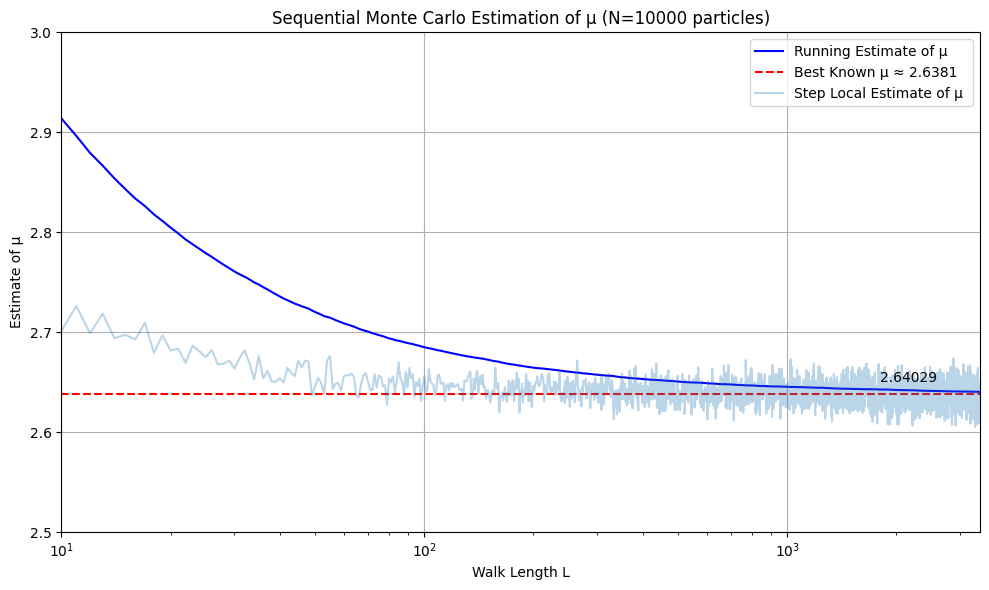

In [ ]:
log_ratios = np.log(ratios)
cumsum_log = np.cumsum(log_ratios)
mu_running = np.exp(cumsum_log / np.arange(1, len(ratios)+1))

plt.figure(figsize=(10,6))
L_range = np.arange(1, len(ratios)+1)

final_L = len(L_range)
final_mu = mu_running[-1]

plt.plot(L_range, mu_running, label=r'Running Estimate of μ', color='blue')
plt.axhline(2.6381, linestyle='--', color='red', label="Best Known μ ≈ 2.6381")

plt.xlim(10, final_L)
plt.ylim(2.5, 3)
plt.xlabel("Walk Length L")
plt.ylabel(r"Estimate of μ")
plt.title(r"Sequential Monte Carlo Estimation of μ (N=10000 particles)")
plt.plot(range(1, len(ratios)+1), ratios, label="Step Local Estimate of μ ", alpha=0.3)
plt.text(1800, 2.647, f"{final_mu:.5f}", fontsize=10, ha='left', va='bottom')
plt.legend()
plt.grid(True)
plt.xscale('log')
plt.tight_layout()
plt.show()


Multiple SMC

In [ ]:
dirs = [(0,1), (0,-1), (1,0), (-1,0)]

def add(p, d):
    return (p[0] + d[0], p[1] + d[1])

# Unvisited neighbors
def get_unvisited_neighbors(walk):
    visited = set(walk)
    head = walk[-1]
    return [add(head, d) for d in dirs if add(head, d) not in visited]

# Resampling based on weights
def resample(walks, weights, N):
    weights = np.array(weights)
    if weights.sum() == 0:
        return walks  # avoid division by zero
    weights = weights / weights.sum()
    indices = np.random.choice(len(walks), size=N, p=weights)
    return [walks[i][:] for i in indices]

# Optional: count duplicates (debugging)
def count_duplicates(walks):
    walk_tuples = [tuple(walk) for walk in walks]
    counter = Counter(walk_tuples)
    duplicates = {walk: count for walk, count in counter.items() if count > 1}
    return len(duplicates)

# Pivot move for diversity
def pivot_move(walk):
    if len(walk) <= 2:
        return walk
    pivot_index = random.randint(1, len(walk) - 2)
    pivot_point = walk[pivot_index]
    direction = random.choice(["rotate90", "rotate270", "reflect_x", "reflect_y"])
    transformed = []

    for i in range(pivot_index + 1, len(walk)):
        dx = walk[i][0] - pivot_point[0]
        dy = walk[i][1] - pivot_point[1]
        if direction == "rotate90":
            new_dx, new_dy = -dy, dx
        elif direction == "rotate270":
            new_dx, new_dy = dy, -dx
        elif direction == "reflect_x":
            new_dx, new_dy = dx, -dy
        elif direction == "reflect_y":
            new_dx, new_dy = -dx, dy
        new_pos = (pivot_point[0] + new_dx, pivot_point[1] + new_dy)
        transformed.append(new_pos)

    new_walk = walk[:pivot_index + 1] + transformed
    if len(set(new_walk)) == len(new_walk):
        return new_walk
    return walk

# Single SMC run
def smc(N=1000, max_L=1000):
    walks = [[(0, 0)] for _ in range(N)]
    extension_ratios = []

    for L in range(1, max_L+1):
        new_walks = []
        weights = []

        for walk in walks:
            candidates = get_unvisited_neighbors(walk)
            w = len(candidates)
            weights.append(w)

            if w > 0:
                step = random.choice(candidates)
                walk.append(step)
                new_walks.append(walk)
            else:
                new_walks.append(walk)

        walks = resample(new_walks, weights, N)
        walks = [pivot_move(walk) for walk in walks]
        extension_ratios.append(np.mean(weights))

    return np.array(extension_ratios)

# Multiple runs
def multiple_runs_smc(num_runs=20, N=1000, max_L=1000):
    all_ratios = []

    for run in tqdm(range(num_runs), desc="Running Multiple SMC Simulations"):
        ratios = smc(N=N, max_L=max_L)
        all_ratios.append(ratios)

    # Pad shorter runs if needed
    max_len = max(len(r) for r in all_ratios)
    for r in all_ratios:
        r.resize(max_len, refcheck=False)
        r[np.isnan(r)] = 0

    all_ratios = np.array(all_ratios)
    mean_ratios = np.nanmean(all_ratios, axis=0)
    std_ratios = np.nanstd(all_ratios, axis=0)

    log_ratios = np.log(mean_ratios)
    cumsum_log = np.cumsum(log_ratios)
    mu_L = np.exp(cumsum_log / np.arange(1, len(log_ratios)+1))


    return mu_L, mean_ratios, std_ratios

# Run everything
mu_L, mean_ratios, std_ratios = multiple_runs_smc(num_runs=20, N=1000, max_L=2300)



Running Multiple SMC Simulations: 100%|██████████| 20/20 [6:53:22<00:00, 1240.15s/it]


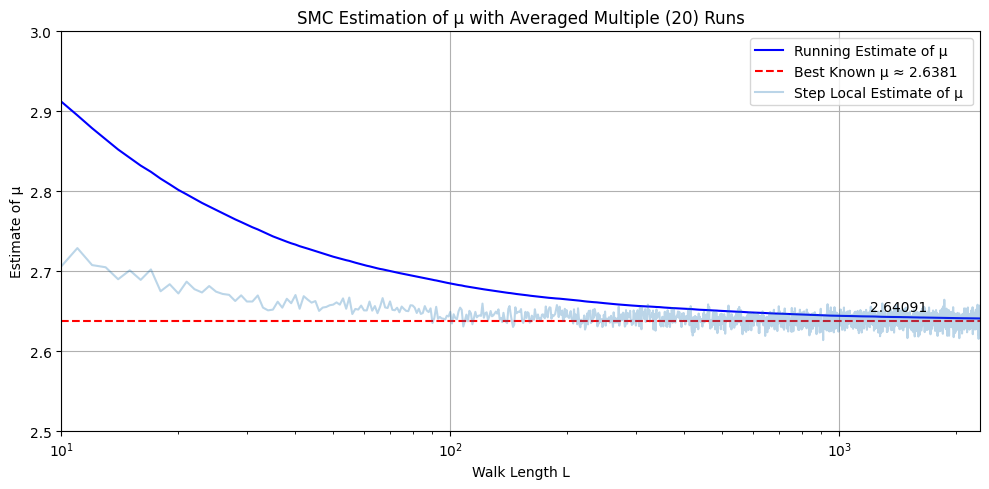

In [ ]:
final_L = len(mu_L)
final_mu = mu_L[-1]

plt.figure(figsize=(10, 5))
L_range = range(1, len(mu_L) + 1)
plt.plot(L_range, mu_L, label=f"Running Estimate of μ", color='blue')
plt.axhline(2.6381, linestyle='--', color='red', label="Best Known μ ≈ 2.6381")
plt.xlim(10, final_L)
plt.ylim(2.5, 3)
plt.xscale("log")
plt.xlabel("Walk Length L")
plt.ylabel("Estimate of μ")
plt.plot(range(1, len(mu_L)+1), mean_ratios, label="Step Local Estimate of μ ", alpha=0.3)
plt.title("SMC Estimation of μ with Averaged Multiple (20) Runs")
plt.text(1200, 2.647, f"{final_mu:.5f}", fontsize=10, ha='left', va='bottom')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Pivot with Recursion

In [ ]:
symmetry_matrices = np.array([
    [[0, -1], [1, 0]],    # rotate 90°
    [[-1, 0], [0, -1]],   # rotate 180°
    [[0, 1], [-1, 0]],    # rotate 270°
    [[1, 0], [0, -1]],    # reflect x-axis
    [[-1, 0], [0, 1]],    # reflect y-axis
    [[0, 1], [1, 0]],     # reflect about y = x
    [[0, -1], [-1, 0]]    # reflect about y = -x
], dtype=np.int32)

@njit
def mat_apply(mat, dx, dy):
    x_new = mat[0, 0] * dx + mat[0, 1] * dy
    y_new = mat[1, 0] * dx + mat[1, 1] * dy
    return x_new, y_new

@njit
def is_self_avoiding(walk):
    seen = set()
    for i in range(walk.shape[0]):
        key = (walk[i, 0], walk[i, 1])
        if key in seen:
            return False
        seen.add(key)
    return True

@njit
def apply_pivot(walk, pivot, mat):
    new_walk = walk.copy()
    px, py = new_walk[pivot]
    for i in range(pivot + 1, new_walk.shape[0]):
        dx = new_walk[i, 0] - px
        dy = new_walk[i, 1] - py
        dx_new, dy_new = mat_apply(mat, dx, dy)
        new_walk[i, 0] = px + dx_new
        new_walk[i, 1] = py + dy_new
    return new_walk

@njit
def generate_saw(N, steps=5000):
    """
    Generate a self-avoiding walk of length N using the pivot algorithm.
    steps = number of pivot trials to reach equilibrium
    """
    walk = np.zeros((N + 1, 2), dtype=np.int32)
    for i in range(1, N + 1):
        walk[i, 0] = walk[i - 1, 0] + 1

    for _ in range(steps):
        pivot = np.random.randint(0, N)
        sym_idx = np.random.randint(0, len(symmetry_matrices))
        mat = symmetry_matrices[sym_idx]
        new_walk = apply_pivot(walk, pivot, mat)
        if is_self_avoiding(new_walk):
            walk = new_walk
    return walk

@njit(parallel=True)
def generate_saw_pool(L, num_samples):
    pool = np.empty((num_samples, L + 1, 2), dtype=np.int32)
    for i in prange(num_samples):
        pool[i] = generate_saw(L, 5000)
    return pool

@njit(parallel=True)
def estimate_B_from_pool(pool, num_pair_trials):
    num_samples = pool.shape[0]
    L = pool.shape[1] - 1
    count = 0
    for i in prange(num_pair_trials):
        idx1 = np.random.randint(0, num_samples)
        idx2 = np.random.randint(0, num_samples)
        walk1 = pool[idx1]
        walk2 = pool[idx2]

        offset = walk1[-1]
        shift = walk2 - walk2[0] + offset

        combined = np.zeros((2 * L + 1, 2), dtype=np.int32)
        for j in range(L + 1):
            combined[j] = walk1[j]
        for j in range(1, L + 1):
            combined[L + j] = shift[j]

        if is_self_avoiding(combined):
            count += 1

    return count / num_pair_trials

def estimate_log_c2L_from_L(log_cL, L, num_samples=10000, num_pair_trials=100000):
    pool = generate_saw_pool(L, num_samples)
    B = estimate_B_from_pool(pool, num_pair_trials)
    if B == 0:
        raise ValueError("B = 0 encountered; log undefined")
    log_B = np.log(B)
    return log_B + 2 * log_cL, B

def estimate_mu(log_cN, N):
    return np.exp(log_cN / N)

# === STARTING POINT ===
known_log_c = {10: np.log(44100)}
mu_values = []

start_L = 10
target_L = 20480
current_L = start_L

with tqdm(total=int(np.log2(target_L // start_L)), desc="Estimating mu_L as L Doubles") as pbar:
    while current_L < target_L:
        log_cL = known_log_c[current_L]
        log_c2L, B = estimate_log_c2L_from_L(
            log_cL, current_L, num_samples=10000, num_pair_trials=1000000
        )

        next_L = current_L * 2
        known_log_c[next_L] = log_c2L

        mu_L = estimate_mu(log_c2L, next_L)
        mu_values.append((next_L, mu_L))

        print(f"L = {next_L}, B = {B:.5f}, log(c) = {log_c2L:.2f}, $\\mu_L \\approx$ {mu_L:.6f}")
        current_L = next_L
        pbar.update(1)


Estimating mu_L as L Doubles:   9%|▉         | 1/11 [00:46<07:48, 46.85s/it]

L = 20, B = 0.45999, log(c) = 20.61, $\mu_L \approx$ 2.802731


Estimating mu_L as L Doubles:  18%|█▊        | 2/11 [01:37<07:22, 49.21s/it]

L = 40, B = 0.36713, log(c) = 40.22, $\mu_L \approx$ 2.733393


Estimating mu_L as L Doubles:  27%|██▋       | 3/11 [03:08<09:05, 68.23s/it]

L = 80, B = 0.29856, log(c) = 79.23, $\mu_L \approx$ 2.692403


Estimating mu_L as L Doubles:  36%|███▋      | 4/11 [05:27<11:12, 96.09s/it]

L = 160, B = 0.23855, log(c) = 157.04, $\mu_L \approx$ 2.668393


Estimating mu_L as L Doubles:  45%|████▌     | 5/11 [10:04<16:07, 161.23s/it]

L = 320, B = 0.18299, log(c) = 312.37, $\mu_L \approx$ 2.654269


Estimating mu_L as L Doubles:  55%|█████▍    | 6/11 [17:42<21:50, 262.11s/it]

L = 640, B = 0.14807, log(c) = 622.84, $\mu_L \approx$ 2.646359


Estimating mu_L as L Doubles:  64%|██████▎   | 7/11 [34:09<33:16, 499.15s/it]

L = 1280, B = 0.11618, log(c) = 1243.52, $\mu_L \approx$ 2.641913


Estimating mu_L as L Doubles:  73%|███████▎  | 8/11 [1:03:34<45:07, 902.36s/it]

L = 2560, B = 0.08917, log(c) = 2484.63, $\mu_L \approx$ 2.639419


Estimating mu_L as L Doubles:  82%|████████▏ | 9/11 [2:10:17<1:02:22, 1871.40s/it]

L = 5120, B = 0.06966, log(c) = 4966.60, $\mu_L \approx$ 2.638046


Estimating mu_L as L Doubles:  91%|█████████ | 10/11 [4:12:49<59:23, 3563.56s/it] 

L = 10240, B = 0.05842, log(c) = 9930.35, $\mu_L \approx$ 2.637315


Estimating mu_L as L Doubles: 100%|██████████| 11/11 [9:00:24<00:00, 2947.68s/it]

L = 20480, B = 0.05296, log(c) = 19857.77, $\mu_L \approx$ 2.636936


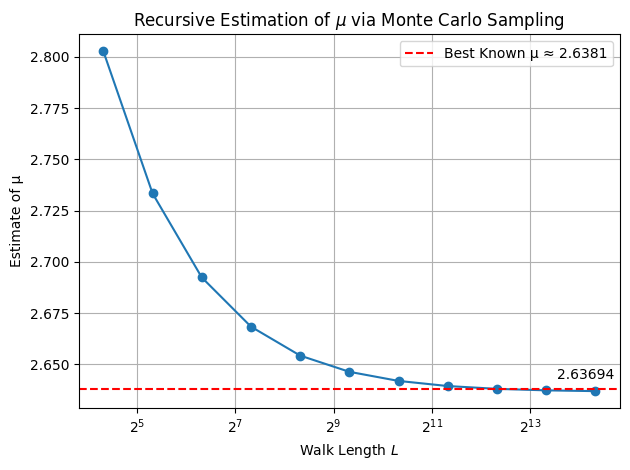

Final estimate at L = 20480: $\mu_L \approx$ 2.636936


In [ ]:
Ls, mus = zip(*mu_values)
final_mu = mus[-1]

plt.plot(Ls, mus, marker='o')
plt.axhline(2.6381, linestyle='--', color='red', label="Best Known μ ≈ 2.6381")
plt.text(12000, 2.6415, f"{final_mu:.5f}", fontsize=10, ha='left', va='bottom')
plt.xscale('log', base=2)
plt.xlabel(r"Walk Length $L$")
plt.ylabel("Estimate of μ")
plt.title(r"Recursive Estimation of $\mu$ via Monte Carlo Sampling")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Final estimate at L = {current_L}: $\\mu_L \\approx$ {mus[-1]:.6f}")